In [1]:
import numpy as np
import cv2 
import matplotlib.pyplot as plt

videofile = './Novgorod_2019-04-05-15_15_00.mp4'


In [2]:
%matplotlib inline
plt.rcParams["figure.figsize"] = (10, 7)

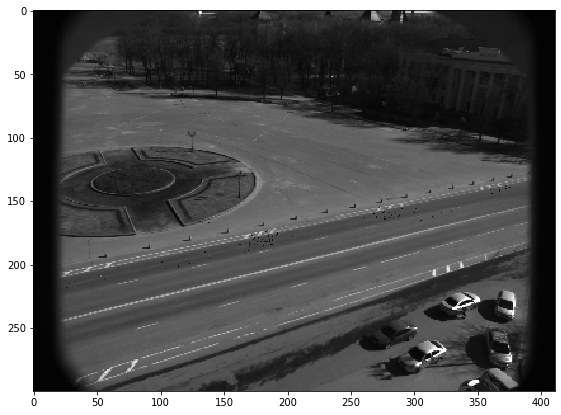

In [21]:
def get_background(filename, iters=10):
    cap = cv2.VideoCapture(filename)
    _, frame_1 = cap.read()
    frame_1 = cv2.resize(frame_1, dsize=tuple(np.array(frame_1.shape[:2][::-1])//10))
    background = frame_1
    for _ in range(iters-1):
        ret, frame_2 = cap.read()
        frame_2 = cv2.resize(frame_2, dsize=tuple(np.array(frame_2.shape[:2][::-1])//10))
        if not ret:
            return background
        
        background = np.where(frame_1 == frame_2, frame_1, background)
        frame_1 = frame_2

    cap.release()
    return background

bg = get_background(videofile, 70)
plt.imshow(bg)

In [18]:
fgbg = cv2.createBackgroundSubtractorMOG2(history=500, detectShadows=True)

def train_bg_subtractor(inst, videofile, num=500):
    cap = cv2.VideoCapture(videofile)
    for _ in range(num):
        ret, frame = cap.read()
        if not ret:
            break
        frame = cv2.resize(frame, dsize=tuple(np.array(frame.shape[:2][::-1])//10))
        inst.apply(frame, None, 0.001)
    cap.release()

train_bg_subtractor(fgbg, videofile, num=500)

In [17]:
cap = cv2.VideoCapture(videofile)

while(1):
    ret, frame = cap.read()
    frame = cv2.resize(frame, dsize=tuple(np.array(frame.shape[:2][::-1])//10))
    fgmask = fgbg.apply(frame)
#     fgmask = cv2.morphologyEx(fgmask, cv2.MORPH_OPEN, kernel)

    cv2.imshow('frame',fgmask)
    k = cv2.waitKey(30) & 0xff
    if k == 27:
        break

cap.release()
cv2.destroyAllWindows()

In [129]:
def get_centroid(x, y, w, h):
    x1 = int(w / 2)
    y1 = int(h / 2)

    cx = x + x1
    cy = y + y1

    return (cx, cy)

def detect_vehicles(fg_mask, min_contour_width=35, min_contour_height=35):

    saved_matches = dict()

    # finding external contours
    contours, _ = cv2.findContours(
        fg_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_TC89_L1)

    # filtering by with, height
    for i, contour in enumerate(contours):
        x, y, w, h = cv2.boundingRect(contour)
        if w < min_contour_width or h < min_contour_height:
            continue

        # getting center of the bounding box
        centroid = get_centroid(x, y, w, h)
#         print(contour)
        saved_matches[centroid] = contour
    return saved_matches


In [158]:
def add_track(new_borders: dict, pool: dict, center_rad=30):
    tracked = dict()
    if not pool:
        for i, new_center in enumerate(new_borders):
            tracked[i] = {
                'center': new_center,
                'box': new_borders[new_center],
                'color': (np.random.randint(50, 240), np.random.randint(50, 240), np.random.randint(50, 240))
            }
    new_borders_copy = new_borders.copy()
    # updating old centers
    for i, new_center in enumerate(new_borders):

        for track in pool:
            if np.abs(new_center[0] - pool[track]['center'][0]) < center_rad and \
               np.abs(new_center[1] - pool[track]['center'][1]) < center_rad:
#                 print("Updated")
                tracked[track] = pool[track]
                tracked[track]['center'] = new_center
                tracked[track]['box'] = new_borders[new_center]
                new_borders_copy.pop(new_center)
                break
    # adding new
    for i, new_center in enumerate(new_borders_copy):
#         print("New")
        new_idx = len(pool) + i
        tracked[new_idx] = {
            'center': new_center,
            'box': new_borders[new_center],
            'color': (np.random.randint(50, 240), np.random.randint(50, 240), np.random.randint(50, 240))
        }
    return tracked

def check_remove(pool: dict, frame_size: tuple, frame_offset=50):
    tracks = dict()
    for track in pool:
        if pool[track]['center'][0] < frame_offset or pool[track]['center'][0] > frame_size[0] - frame_offset:
            continue
        if pool[track]['center'][1] < frame_offset or pool[track]['center'][1] > frame_size[1] - frame_offset:
            continue
        tracks[track] = pool[track]
    return tracks

def draw_boxes(pool: dict, frame):
    frame_with_bords = frame
    for track in pool:
        box = np.int0(cv2.boxPoints(cv2.minAreaRect(pool[track]['box'])))
#         print(box)
        frame_with_bords = cv2.drawContours(frame_with_bords.copy(), [box], 0, pool[track]['color'], 2)
    return frame_with_bords

In [159]:
import traceback
from sys import exc_info
from time import sleep

cap = cv2.VideoCapture(videofile)
tracks = dict()
while cap.isOpened():
    try:
        ret, frame = cap.read()
        key = cv2.waitKey(1)
        if key & 0xFF == ord('q') or not ret:
            cv2.destroyAllWindows()
            cap.release()
            break
        
        new_size = tuple((np.array(frame.shape[:2][::-1])/10).astype(np.int16))
        frame = cv2.resize(frame, dsize=new_size)
        
        threshed = (cv2.bitwise_xor(bg, frame)[:,:,0] > 50).astype(np.uint8)
        threshed = cv2.medianBlur(threshed, 7)
        
        borders = detect_vehicles(threshed, 10, 12)

        tracks = add_track(borders, tracks, 15)
        tracks = check_remove(tracks, new_size, 50)
        frame_with_tracks = draw_boxes(tracks, frame.copy())
        
#         print(tracks.keys())
        
        cv2.imshow('video', frame_with_tracks)
#         sleep(5)

    except Exception as e:
        exc_info = exc_info()
        traceback.print_exception(*exc_info)
        cv2.destroyAllWindows()
        break
cap.release()

New
New
New
New
New
New
New
New
New
New
New
New
New
New
New
New
New
New
New
New
New
New
New
New
New
New
New
New
New
New
New
New
New
New
New
New
New
New
New
New
New
New
New
New
New
New
New
New
New
New
New
New
New
New
New
New
New
New
New
New
New
New
New
New
New
New
New
New
New
New
New
New
New
New
New
New
New
New
New
New
New
New
New
New
New
New
New
New
New
New
New
New
New
New
New
New
New
New
New
New
New
New
New
New
New
New
New
New
New
New
New
New
New
New
New
New
New
New
New
New
New
New
New
New
New
New
New
New
New
New
New
New
New
New
New
New
New
New
New
New
New
New
New
New
New
New
New
New
New
New
New
New
New
New
New
New
New
New
New
New
New
New
New
New
New
New
New
New
New
New
New
New
New
New
New
New
New
New
New
New
New
New
New
New
New
New
New
New
New
New
New
New
New
New
New
New
New
New
New
New
New
New
New
New
New
New
New
New
New
New
New
New
New
New
New
New
New
New
New
New
New
New
New
New
New
New
New
New
New
New
New
New
New
New
New
New
New
New
New
New
New
New
New
New
New
New
New
New
New
New
